In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.autograd.set_detect_anomaly(True)

In [4]:
batch_size = 64
epochs = 10
lr = 3e-4
alpha = 0.1
gamma = 15

In [5]:
def save_results(file_name, img):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = f"{file_name}"
    _ = plt.imsave(f, npimg)

# Загрузка данных

In [6]:
root = 'data/'

data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
])

train = MNIST(root, train=True, transform=data_transform, download=True)
test = MNIST(root, train=False, transform=data_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# Модель VAE-GAN

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Encoder

In [8]:
class Encoder(nn.Module):
    def __init__(self, channels_img, features_d=64, latent_dim=128, negative_slope=0.2):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(features_d, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.Conv2d(features_d, features_d * 2, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(features_d * 2, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(features_d * 2 * 7 * 7, 2048),
            nn.BatchNorm1d(2048, momentum=0.9),
            nn.LeakyReLU(negative_slope),
        )
        self.mean = nn.Linear(2048, latent_dim)
        self.log_var = nn.Linear(2048, latent_dim)
    def forward(self, x):
        x = self.conv(x)
        h = self.linear(x)
        z_mean = self.mean(h)
        z_log_var = self.log_var(h)

        return z_mean, z_log_var

## Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, features_d=128, negative_slope=0.2):
        super(Decoder, self).__init__()
        self.features_d = features_d
        self.linear = nn.Sequential(
            nn.Linear(features_d, features_d * 2 * 7 * 7),
            nn.BatchNorm1d(features_d * 2 * 7 * 7, momentum=0.9),
            nn.LeakyReLU(negative_slope),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(features_d * 2, features_d, kernel_size=6, stride=2, padding=2),
            nn.BatchNorm2d(features_d, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.ConvTranspose2d(features_d, 32, kernel_size=6, stride=2, padding=2),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, self.features_d * 2, 7, 7)
        x = self.deconv(x)
        return x

## Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, features_d=32, negative_slope=0.2):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, features_d, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(negative_slope),
            nn.Conv2d(features_d, features_d * 4, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(features_d * 4, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear(features_d * 16 * 7 * 7, features_d * 16),
            nn.BatchNorm1d(features_d * 16, momentum=0.9),
            nn.LeakyReLU(negative_slope),
            nn.Linear(features_d * 16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.conv(x)
        x1 = x
        x = self.linear(x)
        return x, x1

## Model

In [11]:
class VAEGAN(nn.Module):
    def __init__(self, img_channels):
        super(VAEGAN, self).__init__()
        self.encoder = Encoder(img_channels)
        self.decoder = Decoder()
        self.discriminator = Discriminator()
        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.discriminator.apply(weights_init)
    def forward(self, x):
        bs = x.size()[0]
        z_mean, z_log_var = self.encoder(x)
        std = z_log_var.mul(0.5).exp_()
        epsilon = Variable(torch.randn(bs, 128)).to(device)
        z = z_mean + std * epsilon
        x_tilda = self.decoder(z)
        return z_mean, z_log_var, x_tilda

# Обучение

In [12]:
vae_gan = VAEGAN(1).to(device)

In [13]:
discriminator = Discriminator().to(device)

In [14]:
real_batch = next(iter(train_loader))

In [15]:
criterion = nn.BCELoss().to(device)
optim_E = torch.optim.RMSprop(vae_gan.encoder.parameters(), lr=lr)
optim_D = torch.optim.RMSprop(vae_gan.decoder.parameters(), lr=lr)
optim_Dis = torch.optim.RMSprop(discriminator.parameters(), lr=lr * alpha)
z_fixed = Variable(torch.randn((64, 128))).to(device)
x_fixed = Variable(real_batch[0]).to(device)

In [16]:
prior, gan, recon = [], [], []
real, fake, dis_prior = [], [], []
for epoch in range(epochs):
    prior_loss_list, gan_loss_list, recon_loss_list = [], [], []
    dis_real_list, dis_fake_list, dis_prior_list = [], [], []
    for i, (data, _) in enumerate(tqdm(train_loader), 0):
        bs = data.size()[0]
        ones_label = Variable(torch.ones(bs, 1)).to(device)
        zeros_label = Variable(torch.zeros(bs, 1)).to(device)
        zeros_label1 = Variable(torch.zeros(64, 1)).to(device)
        datav = Variable(data).to(device)
        _, _, rec_enc = vae_gan(datav)
        z_p = Variable(torch.randn(64, 128)).to(device)
        x_p_tilda = vae_gan.decoder(z_p)
        output = discriminator(datav)[0]
        errD_real = criterion(output, ones_label)
        dis_real_list.append(errD_real.item())
        output = discriminator(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        dis_fake_list.append(errD_rec_enc.item())
        output = discriminator(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        dis_prior_list.append(errD_rec_noise.item())
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        gan_loss_list.append(gan_loss.item())
        optim_Dis.zero_grad()
        gan_loss.backward(retain_graph=True)
        optim_Dis.step()
        output = discriminator(datav)[0]
        errD_real = criterion(output, ones_label)
        output = discriminator(rec_enc)[0]
        errD_rec_enc = criterion(output, zeros_label)
        output = discriminator(x_p_tilda)[0]
        errD_rec_noise = criterion(output, zeros_label1)
        gan_loss = errD_real + errD_rec_enc + errD_rec_noise
        x_l_tilda = discriminator(rec_enc)[1]
        x_l = discriminator(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        err_dec = gamma * rec_loss - gan_loss
        recon_loss_list.append(rec_loss.item())
        optim_D.zero_grad()
        err_dec.backward(retain_graph=True)
        optim_D.step()
        mean, log_var, rec_enc = vae_gan(datav)
        x_l_tilda = discriminator(rec_enc)[1]
        x_l = discriminator(datav)[1]
        rec_loss = ((x_l_tilda - x_l) ** 2).mean()
        prior_loss = 1 + log_var - mean.pow(2) - log_var.exp()
        prior_loss = (-0.5 * torch.sum(prior_loss)) / torch.numel(mean.data)
        prior_loss_list.append(prior_loss.item())
        err_enc = prior_loss + 5 * rec_loss
        optim_E.zero_grad()
        err_enc.backward(retain_graph=True)
        optim_E.step()
    print(f"[{epoch+1}/{epochs}] " + 
                f"gan_loss: {round(gan_loss.item(), 4)} " + 
                f"prior_loss: {round(prior_loss.item(), 4)} " + 
                f"reconstruction_loss: {round(rec_loss.item(), 4)} " + 
                f"discriminator_real_loss: {round(errD_real.item(), 4)} " + 
                f"discriminator_fake_loss: {round(errD_rec_enc.item(), 4)} " + 
                f"discriminator_prior_loss: {round(errD_rec_noise.item(), 4)}")
    prior.append(prior_loss_list); gan.append(gan_loss_list); recon.append(recon_loss_list)
    real.append(dis_real_list); fake.append(dis_fake_list); dis_prior.append(dis_prior_list)
    b = vae_gan(x_fixed)[2]
    b = b.detach()
    c = vae_gan.decoder(z_fixed)
    c = c.detach()
    if epoch == 0:
        save_results(f"images/results/MNIST_rec_noise_first_epoch.png", make_grid((c * 0.5 + 0.5).cpu(), 8))
        save_results(f"images/results/MNIST_rec_first_epoch.png", make_grid((b * 0.5 + 0.5).cpu(), 8))
    if epoch == epochs-1:
        save_results(f"images/results/MNIST_rec_noise_last_epoch.png", make_grid((c * 0.5 + 0.5).cpu(), 8))
        save_results(f"images/results/MNIST_rec_last_epoch.png", make_grid((b * 0.5 + 0.5).cpu(), 8))

100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


[1/10] gan_loss: 1.4956 prior_loss: 0.3255 reconstruction_loss: 0.094 discriminator_real_loss: 0.8106 discriminator_fake_loss: 0.4356 discriminator_prior_loss: 0.2494


100%|██████████| 938/938 [04:57<00:00,  3.15it/s]


[2/10] gan_loss: 1.5271 prior_loss: 0.317 reconstruction_loss: 0.082 discriminator_real_loss: 0.8394 discriminator_fake_loss: 0.4624 discriminator_prior_loss: 0.2253


100%|██████████| 938/938 [04:55<00:00,  3.18it/s]


[3/10] gan_loss: 1.4878 prior_loss: 0.315 reconstruction_loss: 0.0811 discriminator_real_loss: 0.8188 discriminator_fake_loss: 0.4537 discriminator_prior_loss: 0.2153


100%|██████████| 938/938 [05:00<00:00,  3.12it/s]


[4/10] gan_loss: 1.5851 prior_loss: 0.2963 reconstruction_loss: 0.0817 discriminator_real_loss: 0.8786 discriminator_fake_loss: 0.4828 discriminator_prior_loss: 0.2237


100%|██████████| 938/938 [05:05<00:00,  3.07it/s]


[5/10] gan_loss: 1.7356 prior_loss: 0.2932 reconstruction_loss: 0.0823 discriminator_real_loss: 1.0514 discriminator_fake_loss: 0.4834 discriminator_prior_loss: 0.2008


100%|██████████| 938/938 [05:06<00:00,  3.06it/s]


[6/10] gan_loss: 1.4202 prior_loss: 0.2902 reconstruction_loss: 0.0751 discriminator_real_loss: 0.7507 discriminator_fake_loss: 0.4697 discriminator_prior_loss: 0.1998


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


[7/10] gan_loss: 1.3774 prior_loss: 0.294 reconstruction_loss: 0.088 discriminator_real_loss: 0.8335 discriminator_fake_loss: 0.3679 discriminator_prior_loss: 0.176


100%|██████████| 938/938 [04:56<00:00,  3.16it/s]


[8/10] gan_loss: 1.4761 prior_loss: 0.3037 reconstruction_loss: 0.0853 discriminator_real_loss: 0.874 discriminator_fake_loss: 0.4013 discriminator_prior_loss: 0.2009


100%|██████████| 938/938 [05:02<00:00,  3.10it/s]


[9/10] gan_loss: 1.4641 prior_loss: 0.2842 reconstruction_loss: 0.0795 discriminator_real_loss: 0.8473 discriminator_fake_loss: 0.4613 discriminator_prior_loss: 0.1554


100%|██████████| 938/938 [04:53<00:00,  3.20it/s]

[10/10] gan_loss: 1.4961 prior_loss: 0.2798 reconstruction_loss: 0.0817 discriminator_real_loss: 0.9205 discriminator_fake_loss: 0.3987 discriminator_prior_loss: 0.1769


# Результаты

## История обучения

In [22]:
prior_arr = np.array(prior).flatten(); gan_arr = np.array(gan).flatten(); recon_arr = np.array(recon).flatten()
real_arr = np.array(real).flatten(); fake_arr = np.array(fake).flatten()

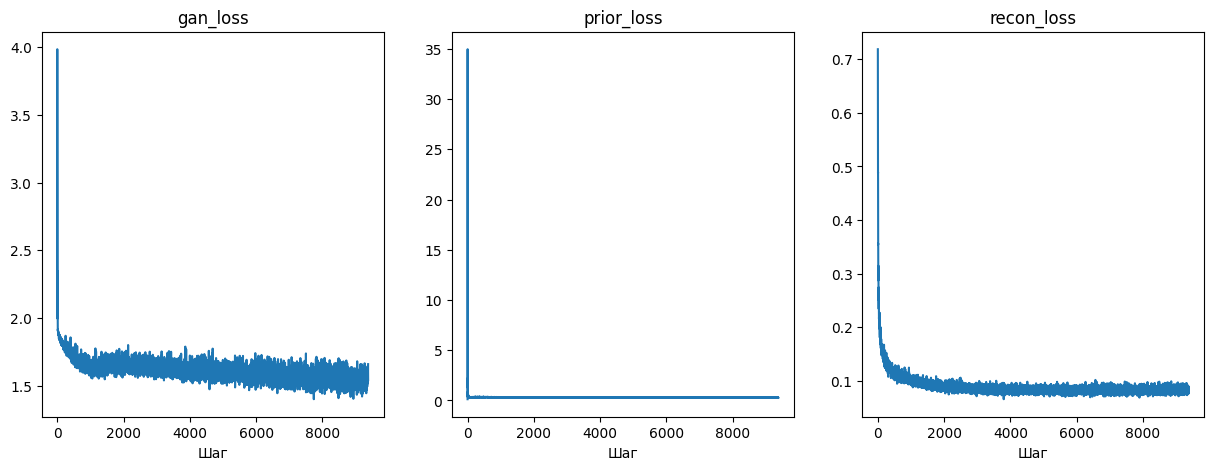

In [38]:
f, ax = plt.subplots(1,3, figsize=(15,5))

_ = ax[0].plot(gan_arr)
_ = ax[0].set_title("gan_loss"); _ = ax[0].set_xlabel("Шаг")

_ = ax[1].plot(prior_arr)
_ = ax[1].set_title("prior_loss"); _ = ax[1].set_xlabel("Шаг")

_ = ax[2].plot(recon_arr)
_ = ax[2].set_title("recon_loss"); _ = ax[2].set_xlabel("Шаг")

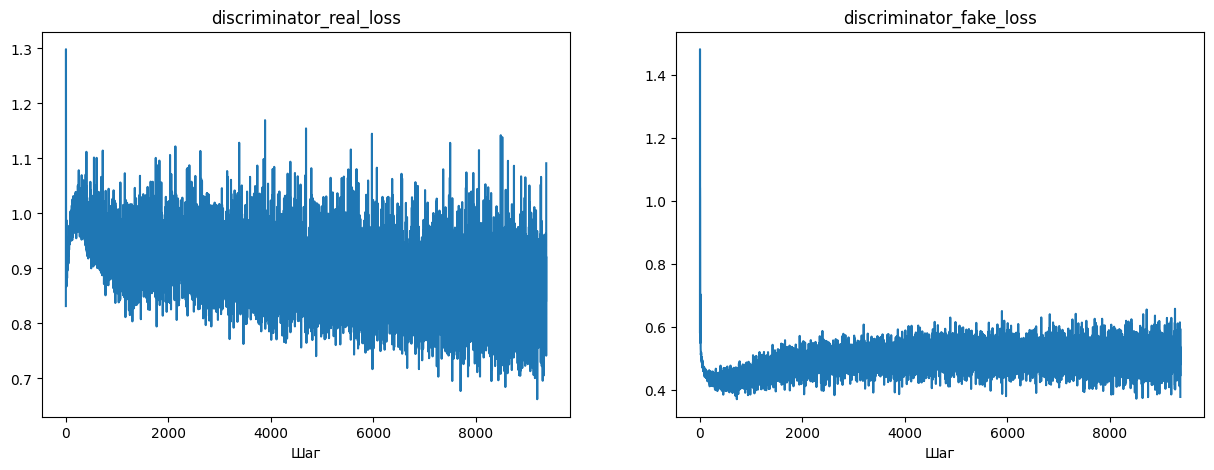

In [41]:
f, ax = plt.subplots(1,2, figsize=(15,5))

_ = ax[0].plot(real_arr)
_ = ax[0].set_title("discriminator_real_loss"); _ = ax[0].set_xlabel("Шаг")

_ = ax[1].plot(fake_arr)
_ = ax[1].set_title("discriminator_fake_loss"); _ = ax[1].set_xlabel("Шаг")

## Пример работы

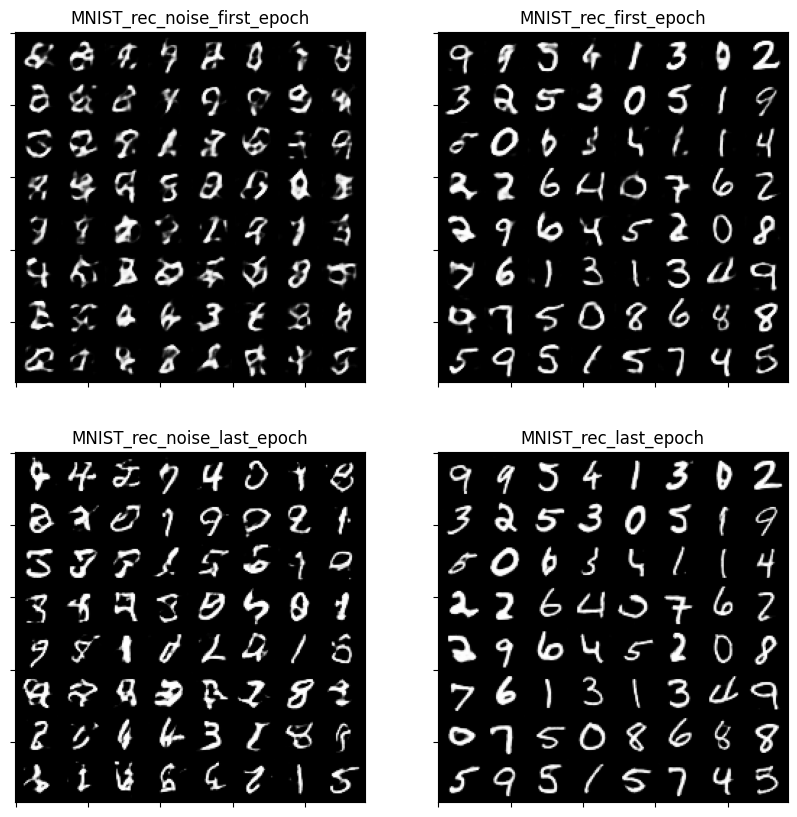

In [40]:
f, ax = plt.subplots(2,2, figsize=(10,10))

_ = ax[0,0].imshow(Image.open("images/results/MNIST_rec_noise_first_epoch.png").convert('RGB'))
_ = ax[0,0].set_title("MNIST_rec_noise_first_epoch"); _ = ax[0,0].set_yticklabels([]); _ = ax[0,0].set_xticklabels([])

_ = ax[0,1].imshow(Image.open("images/results/MNIST_rec_first_epoch.png").convert('RGB'))
_ = ax[0,1].set_title("MNIST_rec_first_epoch"); _ = ax[0,1].set_yticklabels([]); _ = ax[0,1].set_xticklabels([])

_ = ax[1,0].imshow(Image.open("images/results/MNIST_rec_noise_last_epoch.png").convert('RGB'))
_ = ax[1,0].set_title("MNIST_rec_noise_last_epoch"); _ = ax[1,0].set_yticklabels([]); _ = ax[1,0].set_xticklabels([])

_ = ax[1,1].imshow(Image.open("images/results/MNIST_rec_last_epoch.png").convert('RGB'))
_ = ax[1,1].set_title("MNIST_rec_last_epoch"); _ = ax[1,1].set_yticklabels([]); _ = ax[1,1].set_xticklabels([])